# Get Started
You have first to mount your drive to colab local storage then decide which folder of your drive to be used as root directory which will look like this 
(mine) https://drive.google.com/drive/u/4/folders/1j6AmahNcJ3seM7Davwz2CuXCN87FQQjZ 
you can simply add this folder to your drive to get started and then make your own structure of inputs and outputs


# Mounting Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [0]:
!ls "/gdrive/My Drive/Colab Temp-Training"

 foo.txt
 haterheavy-mot-xception-adam-1e-05-imnet
 heavy-mot-xception-adam-1e-05-imnet
 heavy-spa-xception-adam-1e-05-imnet
 heavyspaxception-adam-1e-05-imnet
 medium-mot-xception-adam-1e-05-imnet
 motion_feature_dataset
 mot-xception-adam-5e-05-imnet
 recurrent_fusion_relu
 recurrent_fusion_selu
 recurrent_fusion_selu_atten1e-06
 recurrent_fusion_selu_atten_simple1e-06
 simple-mot-xception-adam-1e-05-imnet
 spatial_feature_dataset
 spa-xception-adam-5e-06-imnet
'Style Transfer Artifacts'
 test-heavy-spa-xception-adam-1e-05-imnet


In [0]:
!ls "/gdrive/My Drive/Colab Temp-Training/Style Transfer Artifacts"

content-block1-conv1  experiment-11  experiment-2   experiment-7
content-block2-conv1  experiment-12  experiment-20  experiment-8
content-block3-conv1  experiment-13  experiment-21  experiment-9
content-block4-conv1  experiment-14  experiment-22  style-block1-conv1
content-block5-conv1  experiment-15  experiment-23  style-block2-conv1
contents	      experiment-16  experiment-3   style-block3-conv1
experiment-0	      experiment-17  experiment-4   style-block4-conv1
experiment-1	      experiment-18  experiment-5   style-block5-conv1
experiment-10	      experiment-19  experiment-6   styles


# Style Transfer

### [Important] for video creation and image re-generation

#### setting path for the notebook

In [0]:
# this directory will be used for input content and style images, also for saving output experiments into folders
root_path = "/gdrive/My Drive/Colab Temp-Training/Style Transfer Artifacts/"

#### install + import

In [0]:
# installations
!pip install opencv-python
!pip install sk-video

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import backend as K
import cv2
import matplotlib.pyplot as plt
import numpy as np
from __future__ import absolute_import, division, print_function
%matplotlib inline
import numpy as np
import IPython.display as display
import time
import random
import glob
import shutil
import os

TensorFlow 2.x selected.


### reading / pre-processing input images

In [0]:
# using the root path given, you need to create contents and styles directories
content_root_path = os.path.join(root_path,"contents")
style_root_path = os.path.join(root_path,"styles")

In [0]:
def load_img(path,size=None):
    max_dim = 512

    img =  cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) 
    long_dim = max(img.shape)

    scale = max_dim / long_dim

    if size :
        img=cv2.resize(img,size[1:3][::-1])
    else:
        img=cv2.resize(img,(int(img.shape[1]*scale),int(img.shape[0]*scale)))
    
    img=np.expand_dims(img, axis=0)
    return img

In [0]:
content_path=os.path.join(content_root_path,random.choice(os.listdir(content_root_path)))
style_path=os.path.join(style_root_path,random.choice(os.listdir(style_root_path)))
print(content_path,"\n",style_path)

/gdrive/My Drive/Colab Temp-Training/Style Transfer Artifacts/contents/me 1.jpg 
 /gdrive/My Drive/Colab Temp-Training/Style Transfer Artifacts/styles/the_shipwreck_of_the_minotaur.jpg


In [0]:
content_path="/gdrive/My Drive/Colab Temp-Training/Style Transfer Artifacts/contents/me 2.jpg"
style_path="/gdrive/My Drive/Colab Temp-Training/Style Transfer Artifacts/styles/picasso2.jpg"

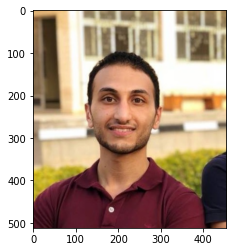

In [0]:
content_image = load_img(content_path)
plt.imshow(content_image.squeeze())

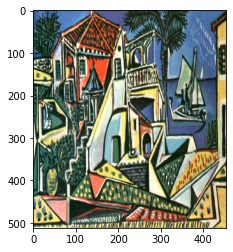

In [0]:
style_image = load_img(style_path,content_image.shape)
plt.imshow(style_image.squeeze())

## custom vgg19 model

In [0]:
class VGG_extractor(tf.keras.models.Model):
  def __init__(self, feature_list,avg_pool=True):
    super(VGG_extractor, self).__init__()
    self.feature_list = []
    self.avg_pool = avg_pool
    self.extractor = self.define_vgg19_extractor(feature_list)

  def define_vgg19_extractor(self,feature_list):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    custom_inputs = tf.keras.layers.Input(shape=(None,None,3))
    x = custom_inputs
    outputs = []

    for layer in vgg.layers:
        if "input" not in layer.name:
            if "pool" in layer.name:
                if self.avg_pool :
                    x=tf.keras.layers.AveragePooling2D((2, 2), strides=(2, 2), name=layer.name.replace("pool","personal_max_pool"))(x)
                else:
                    x=tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name=layer.name.replace("pool","personal_max_pool"))(x)
            else:
                x=layer(x)

        # append to the outputs
        if layer.name in feature_list:
            outputs.append(x)
            self.feature_list.append(layer.name)

        # stop if all required layers are added to the outputs 
        if len(self.feature_list) == len(feature_list):
            break


    #  return tf.keras.models.Model(inputs=custom_inputs, outputs=x) sanity check
    return tf.keras.models.Model(inputs=custom_inputs, outputs=outputs)

  def dictionarify_output(self,outputs):
    return dict(zip(self.feature_list,outputs))

  def call(self, inputs):
    "Expects int input in [0,255]"   
    inputs = tf.cast(inputs,tf.float32)
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) # always check the docs for exact input range and type

    outputs = self.extractor(preprocessed_input)
   
    return self.dictionarify_output(outputs) # from list into dictionary

# losses and representational helper functions

## helper squared loss

In [0]:
def squared_error(represtentation_a,represtentation_b):
  return K.sum(K.square(represtentation_a-represtentation_b)) 

## style loss and representation

In [0]:
# for efficiency I won't compute the normalization factor with each iteration

#  N = layer_responses.shape[-1] # number of feature maps
#  M = 3 # kernel dim
# normalization_formula = 1/(4* M^2 * N^2)

normalization_dict = {'block1_conv1': 1 / (4 * 64 * 64 * 3 * 3),
                      'block2_conv1': 1 / (4 * 128 * 128 * 3 * 3),
                      'block3_conv1': 1 / (4 * 256 * 256 * 3 * 3),
                      'block4_conv1': 1 / (4 * 512 * 512 * 3 * 3),
                      'block5_conv1': 1 / (4 * 512 * 512 * 3 * 3)
                      }

In [0]:
def gram_representation(layer_responses):
    layer_responses = tf.reshape(layer_responses,(-1,layer_responses.shape[-1]))
    gram = tf.matmul(tf.transpose(layer_responses),layer_responses)
    return gram
    

In [0]:
# the paper uses a weighted sum of the gram matrices of the layers(i.e. style layers) responses
def style_loss(generation_responses,style_layers,style_weights):
    result = 0 
    for style_layer in style_layers :
        result += style_weights[style_layer]*normalization_dict[style_layer]*(squared_error(gram_representation(generation_responses[style_layer]),gram_style_responses[style_layer]))
    return result

## content loss

In [0]:
# the paper uses only one content layer for reconstruction
def content_loss(generation_responses,content_layers):
    result = 0 
    for content_layer in content_layers :
        result += .5*(squared_error(generation_responses[content_layer], content_responses[content_layer]))
    return result


## variational loss

In [0]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

In [0]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

## total loss

In [0]:
def total_loss(generated_image,content_layers,style_layers,style_weights,content_loss_weight,style_loss_weight,variational_loss_weight):
    generation_responses = extractor(generated_image)
    total_loss_tf = 0 

    content_loss_tf=content_loss(generation_responses,content_layers)
    if content_loss_weight > 0:
        total_loss_tf = content_loss_weight*content_loss_tf

    style_loss_tf=style_loss(generation_responses,style_layers,style_weights)
    if style_loss_weight > 0:
        total_loss_tf += style_loss_weight*style_loss_tf

    variational_loss_tf =tf.image.total_variation(generated_image)
    if variational_loss_weight > 0:
        total_loss_tf += variational_loss_weight*variational_loss_tf

    return total_loss_tf

# optimization and generation step

In [0]:
def clip_0_255(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)

In [0]:
@tf.function()
def train_step(generated_image,opt,content_layers,style_layers,style_weights,content_loss_weight,style_loss_weight,variational_loss_weight):
    # generated_image : 0 to 255
    with tf.GradientTape() as tape:
        loss = total_loss(generated_image,content_layers,style_layers,style_weights,content_loss_weight,style_loss_weight,variational_loss_weight)

    grad = tape.gradient(loss,generated_image)
    opt.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_255(generated_image))


# precomputing source style and content representation

In [0]:
# Content layer where will pull our feature maps
content_layers = [
                'block4_conv2' 
                ] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1',
                ]

extractor = VGG_extractor(style_layers+content_layers)

In [0]:
style_weights = {'block1_conv1': .2  ,
                 'block2_conv1': .2  ,
                 'block3_conv1': .2  ,
                 'block4_conv1': .2  ,
                 'block5_conv1': .2  } 

In [0]:
style_responses,content_responses = extractor(style_image) , extractor(content_image)

# get gram representation of style responses
gram_style_responses = {layer_name:gram_representation(style_response) for layer_name,style_response in style_responses.items()}

## output image processing (color perservation)

This following piece of code is adapted from https://github.com/anishathalye/neural-style/blob/master/stylize.py

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def gray2rgb(gray):
    w, h = gray.shape
    rgb = np.empty((w, h, 3), dtype=np.float32)
    rgb[:, :, 2] = rgb[:, :, 1] = rgb[:, :, 0] = gray
    return rgb

In [0]:
def perserve_colors(styled_image, original_image):
    # Luminosity transfer steps:
    # 1. Convert stylized RGB->grayscale accoriding to Rec.601 luma (0.299, 0.587, 0.114)
    # 2. Convert stylized grayscale into YUV (YCbCr)
    # 3. Convert original image into YUV (YCbCr)
    # 4. Recombine (stylizedYUV.Y, originalYUV.U, originalYUV.V)
    # 5. Convert recombined image from YUV back to RGB

    # 1
    styled_grayscale = rgb2gray(styled_image)

    styled_grayscale_rgb = gray2rgb(styled_grayscale)

    # 2
    styled_grayscale_yuv =cv2.cvtColor(styled_grayscale_rgb,cv2.COLOR_RGB2YCR_CB)

    # 3
    original_yuv =cv2.cvtColor(original_image,cv2.COLOR_RGB2YCR_CB)

    # 4
    w, h, _ = original_image.shape
    combined_yuv = np.empty((w, h, 3), dtype=np.uint8)
    combined_yuv[..., 0] = styled_grayscale_yuv[..., 0]
    combined_yuv[..., 1] = original_yuv[..., 1]
    combined_yuv[..., 2] = original_yuv[..., 2]

    # 5
    img_out =cv2.cvtColor(combined_yuv,cv2.COLOR_YCR_CB2RGB)

    return (img_out * .2 + styled_image * .8).astype(np.uint8)

# image generation / reconstruction

In [0]:
def experiment(content_layers,style_layers,style_weights,content_loss_weight=1,style_loss_weight=1e-10,variational_loss_weight=1e-3,init="content",learning_rate=.5,imgs_path="",capture_frame_every=50):
    if init=="content":
        generated_image = tf.Variable(content_image,dtype=tf.float32)
    else : # random
        generated_image = tf.Variable(np.random.randint(0,255,size=content_image.shape),dtype=tf.float32)

    opt = tf.optimizers.Adam(learning_rate=learning_rate)

    reconstruction_loop(generated_image,opt,content_layers,style_layers,style_weights,content_loss_weight,style_loss_weight,variational_loss_weight,imgs_path,capture_frame_every)

I write both the original network generation and also a little bit colour corrected version adapted from https://github.com/anishathalye/neural-style/blob/master/stylize.py

In [0]:
def reconstruction_loop(generated_image,opt,content_layers,style_layers,style_weights,content_loss_weight,style_loss_weight,variational_loss_weight,imgs_path,capture_frame_every):
    start = time.time()

    for i in range(2001):
        if i % capture_frame_every ==0:
            generated_uint8_rgb = generated_image.numpy().squeeze(axis=0).astype(np.uint8) 
         
            cv2.imwrite("{}/{}.png".format(imgs_path,i),cv2.cvtColor(generated_uint8_rgb, cv2.COLOR_RGB2BGR))
            #cv2.imwrite("{}/{}-perserved.png".format(imgs_path,i),cv2.cvtColor(perserve_colors(generated_uint8_rgb,content_image.squeeze(axis=0)), cv2.COLOR_RGB2BGR))

            print("saving","{}/{}.png".format(imgs_path,i))

            
            display.clear_output(wait=True)
            
            
        train_step(generated_image,opt,content_layers,style_layers,style_weights,content_loss_weight,style_loss_weight,variational_loss_weight)
    end = time.time()
    print("Total time: {:.1f}".format(end-start))
    plt.imshow(generated_uint8_rgb)

## Experiment
for each experiment I create a folder with experiment number (you have to review your drive folder shared with this notebook, you may also rename them from web drive)

In [0]:
# you need to redefine this with every experiment
@tf.function()
def train_step(generated_image,opt,content_layers,style_layers,style_weights,content_loss_weight,style_loss_weight,variational_loss_weight):
    # generated_image : 0 to 255
    with tf.GradientTape() as tape:
        loss = total_loss(generated_image,content_layers,style_layers,style_weights,content_loss_weight,style_loss_weight,variational_loss_weight)

    grad = tape.gradient(loss,generated_image)
    opt.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_255(generated_image))


#### Style transfer experiment

In [0]:
experiment_index = len(glob.glob(os.path.join(root_path,"experi*")))
imgs_path = os.path.join(root_path,"experiment-"+str(experiment_index)) # output images path 
os.mkdir(imgs_path)
print("create:",imgs_path)

create: /gdrive/My Drive/Colab Temp-Training/Style Transfer Artifacts/experiment-35


Total time: 98.1


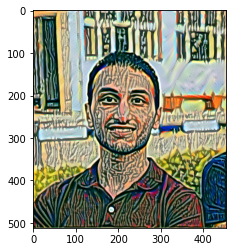

In [0]:
experiment(
    content_layers = content_layers,
    style_layers = style_layers,
    style_weights = style_weights,
    style_loss_weight=1e3, 
    variational_loss_weight= 1e1,
    content_loss_weight= 1,
    init="content",
    learning_rate = .2,
    imgs_path=imgs_path,
    capture_frame_every = 10
)

#### Reconstruction from layer experiment (similar to fig 1 in Gatys'neural algorithm of artistic style)

In [0]:
imgs_path = os.path.join(root_path,"style-block1-conv1") # output images path 

if os.path.isdir(imgs_path):
    shutil.rmtree(imgs_path)

os.mkdir(imgs_path)
print("create:",imgs_path)

Total time: 46.7


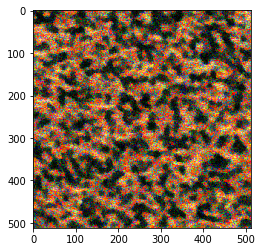

In [0]:
# control style_loss_weight,content_loss_weight by setting one of them as zero will generate the other
# you may need to change content_layers and style_layers above
# the initialization would be random not the content image

experiment(
    content_layers = content_layers,
    style_layers = style_layers,
    style_weights = style_weights,
    style_loss_weight=1e3, 
    variational_loss_weight= 1e1,
    content_loss_weight= 0,
    init="random",
    learning_rate = .2,
    imgs_path=imgs_path,
    capture_frame_every = 10
)

### remove bad experiments

In [0]:
shutil.rmtree(imgs_path)

# Generating Video Demos

In [0]:
import base64
from IPython.display import HTML
import io

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skvideo.io
from matplotlib import gridspec

## live-demo style transfer

In [0]:
print(sorted(list(map(lambda item:item[0],experiments))))

['experiment-0', 'experiment-1', 'experiment-10', 'experiment-11', 'experiment-12', 'experiment-13', 'experiment-14', 'experiment-15', 'experiment-16', 'experiment-17', 'experiment-18', 'experiment-2', 'experiment-20', 'experiment-3', 'experiment-4', 'experiment-5', 'experiment-6', 'experiment-7', 'experiment-8', 'experiment-9']


In [0]:
experiments = ['experiment-0',
               'experiment-1',
               'experiment-2',
               'experiment-3', 
               'experiment-4', 
               'experiment-5', 
               'experiment-6', 
               'experiment-7', 
               'experiment-8', 
               'experiment-9',
               'experiment-10',
               'experiment-11',
               'experiment-12', 
               'experiment-13',
               'experiment-14',
               'experiment-15',
               'experiment-16',
               'experiment-17', 
               'experiment-18',
               'experiment-20',
               ]
base_dir = root_path
writer = skvideo.io.FFmpegWriter("demo.mp4", inputdict={
    '-r': '24',
})

experiment = "experiment-2"
#experiment = "experiment-20"
#experiment = "experiment-33"
#experiment = "experiment-30"
#experiment = "experiment-34"
#experiment = "experiment-21"

for i in range(0, 2501, 10):
    if i % 250 == 0:
        print("processing frame ", i)

    if experiment in ["experiment-2", "experiment-20"]:
        frame= cv2.cvtColor(cv2.imread(os.path.join(base_dir, experiment, "{}-perserved.png".format(i))), cv2.COLOR_BGR2RGB) 
    else :
        frame= cv2.cvtColor(cv2.imread(os.path.join(base_dir, experiment, "{}.png".format(i))), cv2.COLOR_BGR2RGB) 
    for i in range(10 if i == 2500 else 1):
        writer.writeFrame(frame)
        writer.writeFrame(frame)
writer.close()

processing frame  0
processing frame  250
processing frame  500
processing frame  750
processing frame  1000
processing frame  1250
processing frame  1500
processing frame  1750
processing frame  2000
processing frame  2250
processing frame  2500


In [0]:
video = io.open("demo.mp4" , 'r+b').read()
encoded = base64.b64encode(video)

HTML(data='''<video controls autoplay loop>
			<source type="video/mp4" src="data:video/mp4;base64,{}"
      		</video>'''.format(encoded.decode('ascii')))

## [Grid] live-demo style transfer

processing frame  0
processing frame  250
processing frame  500
processing frame  750
processing frame  1000
processing frame  1250
processing frame  1500


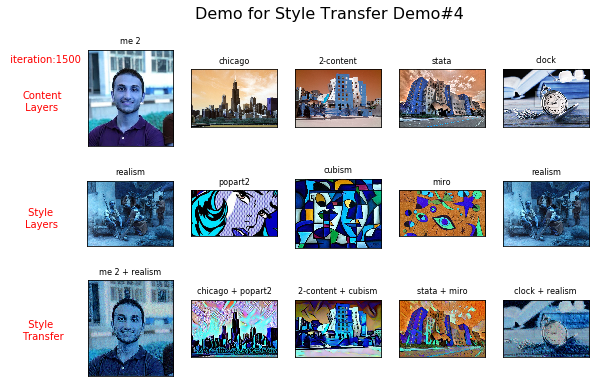

In [0]:
experiments = [
    ("experiment-17", "contents/me 2.jpg", "styles/wave.jpg"),
    ("experiment-18", "contents/chicago.jpg", "styles/dali.jpg"),
    ("experiment-10", "contents/roses.jpeg", "styles/guernica.jpg",),
    ("experiment-1", "contents/avila-walls.jpg", "styles/broca.jpg",),
    ("experiment-2", "contents/stata.jpg", "styles/popart2.jpg",),

    ("experiment-3", "contents/stata.jpg", "styles/renoir.jpg",),
    ("experiment-4", "contents/roses.jpeg", "styles/courbet.jpg",),
    ("experiment-5", "contents/me 2.jpg", "styles/cubism.jpg",),
    ("experiment-6", "contents/clock.jpg", "styles/vangogh2.jpg",),
    ("experiment-7", "contents/liberty.jpg", "styles/fauvism.jpg",),

    ("experiment-8", "contents/chicago.jpg", "styles/munch.jpg",),
    ("experiment-0", "contents/me 1.jpg", "styles/the_scream.jpg",),
    ("experiment-15", "contents/2-content.jpg", "styles/rain_princess.jpg",),
    ("experiment-11", "contents/liberty.jpg", "styles/udnie.jpg",),
    ("experiment-12", "contents/goldengate.jpg", "styles/picasso.jpg",),

    ("experiment-13", "contents/me 2.jpg", "styles/realism.jpg",),
    ("experiment-9", "contents/chicago.jpg", "styles/popart2.jpg",),
    ("experiment-16", "contents/2-content.jpg", "styles/cubism.jpg",),
    ("experiment-20", "contents/stata.jpg", "styles/miro.jpg",),
    ("experiment-14", "contents/clock.jpg", "styles/realism.jpg",)

]
base_dir = root_path
writer = skvideo.io.FFmpegWriter("demo.mp4", inputdict={
    '-r': '24',
})


def get_img_from_fig(fig, dpi=125):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)  # the image is in BGR and now saved with wrong colors to the buffer
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)  # opencv will decode the wrong color image in BGR which means it will be RGB

    return img[:-int(.1 * img.shape[0])]


gs = gridspec.GridSpec(3, 5, )

gs.update(wspace=0.2, hspace=.2)
fig = plt.figure(figsize=(9, 6))

img_artist = [None]*15
for i in range(0, 1501, 10):
    if i % 250 == 0:
        print("processing frame ", i)

    if i == 0 :
        fig.suptitle("Demo for {}".format("Style Transfer Demo#4"), fontsize=16)
        fig.text(0.025, 0.21, "  Style\nTransfer", color='r', fontsize=10)
        fig.text(0.029, 0.47, " Style\nLayers", color='r', fontsize=10)
        fig.text(0.025, 0.74, "Content\n Layers", color='r', fontsize=10)

    fig.text(0.002, .85, " iteration:" + str(i), color='r', fontsize=10, bbox=dict(facecolor='white',edgecolor='white'))

    for j, (experiment, ex_content_img, ex_style_img, content_name,style_name) in enumerate(map(lambda item: (item[0],
                                                                                                    cv2.imread(os.path.join(base_dir, item[1])),
                                                                                                    cv2.imread(os.path.join(base_dir, item[2])),
                                                                                                    item[1].split("/")[1].split(".")[0] ,
                                                                                                    item[2].split("/")[1].split(".")[0]
                                                                                                    )
            , experiments[15:20])):  # will read content & style images only once at start for memory efficiency

        if not img_artist[j] :
            ax = plt.subplot(gs[j])
            ax.set_title(content_name, fontsize=8)
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            img_artist[j] =ax.imshow(ex_content_img)
        else: 
            img_artist[j].set_data(ex_content_img)

        if not img_artist[j+ 5]  :
            ax = plt.subplot(gs[j + 5])
            ax.set_title(style_name, fontsize=8)
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            img_artist[j+ 5]=ax.imshow(ex_style_img)
        else: 
            img_artist[j+ 5].set_data(ex_style_img)

        if not img_artist[j+ 10] :
            ax = plt.subplot(gs[j + 10])
            ax.set_title(content_name+" + "+style_name, fontsize=8)
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            img_artist[j+ 10]=ax.imshow(cv2.imread(os.path.join(base_dir, experiment, "{}-perserved.png".format(i))))
        else:   
            img_artist[j+ 10].set_data(cv2.imread(os.path.join(base_dir, experiment, "{}-perserved.png".format(i))))

    for i in range(10 if i == 1500 else 1):
        writer.writeFrame(get_img_from_fig(fig))
        writer.writeFrame(get_img_from_fig(fig))
writer.close()


In [0]:
video = io.open("demo.mp4" , 'r+b').read()
encoded = base64.b64encode(video)

HTML(data='''<video controls autoplay loop>
			<source type="video/mp4" src="data:video/mp4;base64,{}"
      		</video>'''.format(encoded.decode('ascii')))

## Reconstruction from layers (similar to fig 1 in Gatys'neural algorithm of artistic style)

In [0]:
base_dir = root_path
writer = skvideo.io.FFmpegWriter("demo.mp4", inputdict={
      '-r': '28',
    })


def get_img_from_fig(fig, dpi=125):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi) # the image is in BGR and now saved with wrong colors to the buffer
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1) # opencv will decode the wrong color image in BGR which means it will be RGB

    return img[:-int(.1*img.shape[0])]


gs = gridspec.GridSpec(3, 5, )

gs.update(wspace=0.2, hspace=.2)

for i in range(0,5001,10):
    if i % 500 == 0:
        print("processing frame ",i)

   
    fig = plt.figure(figsize=(9, 6))
    fig.suptitle("Demo for {}".format("Image Reconstruction using VGG19"), fontsize=16)
    fig.text(0.029, 0.21, " Style\nLayers", color='r', fontsize=10)
    fig.text(0.025, 0.47, "Content\n Layers", color='r', fontsize=10)

    fig.text(0.01, .85, " iteration:"+str(i), color='r', fontsize=10)

    ax = plt.subplot(gs[0:2])
    ax.set_title("Original Content Image", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread((os.path.join(root_path,"contents","me 1.jpg"))))

    ax = plt.subplot(gs[2:4])
    ax.set_title("Original Style Image", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread((os.path.join(root_path,"styles","the_scream.jpg"))))

    ax = plt.subplot(gs[4])
    ax.set_title("Style Transfer", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread(os.path.join(base_dir,"experiment-0/","{}.png".format(i))))

    ax = plt.subplot(gs[5])
    ax.set_title("conv1_1", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread(os.path.join(base_dir,"content-block1-conv1/","{}.png".format(i))))

    ax = plt.subplot(gs[6])
    ax.set_title("conv2_1", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread(os.path.join(base_dir,"content-block2-conv1/","{}.png".format(i))))

    ax = plt.subplot(gs[7])
    ax.set_title("conv3_1", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread(os.path.join(base_dir,"content-block3-conv1/","{}.png".format(i))))

    ax = plt.subplot(gs[8])
    ax.set_title("conv4_1", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread(os.path.join(base_dir,"content-block4-conv1/","{}.png".format(i))))

    ax = plt.subplot(gs[9])
    ax.set_title("conv5_1", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread(os.path.join(base_dir,"content-block5-conv1/","{}.png".format(i))))

    ax = plt.subplot(gs[10])
    ax.set_title("conv1_1", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread(os.path.join(base_dir,"style-block1-conv1/","{}.png".format(i))))

    ax = plt.subplot(gs[11])
    ax.set_title("conv1_1\n+conv2_1", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread(os.path.join(base_dir,"style-block2-conv1/","{}.png".format(i))))

    ax = plt.subplot(gs[12])
    ax.set_title("conv1_1+conv2_1+\n+conv3_1", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread(os.path.join(base_dir,"style-block3-conv1/","{}.png".format(i))))

    ax = plt.subplot(gs[13])
    ax.set_title("conv1_1+conv2_1+\nconv3_1+conv4_1", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread(os.path.join(base_dir,"style-block4-conv1/","{}.png".format(i))))

    ax = plt.subplot(gs[14])
    ax.set_title("conv1_1+conv2_1+\n   conv3_1+conv4_1+conv5_1", fontsize=8)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.imread(os.path.join(base_dir,"style-block5-conv1/","{}.png".format(i))))

    for i in range(10 if i == 5000 else 1):
        writer.writeFrame(get_img_from_fig(fig))
    plt.close(fig)

writer.close()




NameError: ignored

In [0]:
video = io.open("demo.mp4" , 'r+b').read()
encoded = base64.b64encode(video)

HTML(data='''<video controls autoplay loop>
			<source type="video/mp4" src="data:video/mp4;base64,{}"
      		</video>'''.format(encoded.decode('ascii')))